Обучите простую модель предсказания цены акций. Используйте рассмотренные на лекции алгоритмы предсказания рядов (не менее двух,например, модель Хольта-Уинтерса и SARIMA). Можно использовать и более сложные алгоритмы предсказания рядов


1. Найдите данные о цене любого биржевого актива

    Данные должны содержать значение цены актива как минимум за каждый день и длительностю как минимум за год. 

    Найти данные можно на kaggle или использовать FAANG датасет из 1-й лабораторной

<font color='yellow'> Набор данных: 
[FAANG dataset](https://www.kaggle.com/datasets/specter7/amazon-amzn-historical-stock-price-data) - Берем данные по Netflix</font>

2. Предобработайте данные

    Временной ряд сложно предсказывать по дням. Сделайте ряд по неделям или месяцам
   
    Удалите из ряда тренд, если он есть. Используйте другие рассмотренные на лекции приёмы


3. Обучите модель
    
    Обучите модели на 80% временного ряда
    
    Предскажите оставшиеся 20% (как минимум 3 точки) ряда с помощью моделей 
    
    Отобразите на графике предсказание моделей и истинные данные


4. Посчитайте метрику

    Метрика должна отражать разницу между предсказанными и истинными данными. Можно выбрать меру MAPE, можно предложить свою

In [1]:
#TASK1 Подготовка, чтение данных, первичный анализ

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels
import numpy as np
import math
import re
import pandas as pd

df = pd.read_csv('data2/Netflix_Historical_StockPrice2.csv')
df.head(3)
#df.shape
#df.info()
#df.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-03-28,98.339996,101.440002,97.820000,101.209999,101.209999,12432200
1,2016-03-29,101.080002,104.330002,101.000000,104.129997,104.129997,16008900
2,2016-03-30,104.650002,104.910004,101.480003,102.190002,102.190002,14705000


,Low
Date,
2016-03-31,100.337502
2016-04-30,99.339999
2016-05-31,91.642381


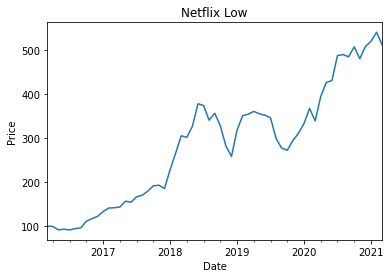

In [2]:
#TASK2.1 Сжимаем ряд
#Сделаем ряд по неделям

#получаем колонку типа datetime из которой можно будет взять номер месяца
df.Date = pd.to_datetime(df.Date, format='%Y/%m/%d')
#заиндексим месяцами и выведем среднее из значений которые были в каждый месяц
df = df.resample('m', on='Date').mean() #cделали гранулярность чтобы упростить структуру
df.head(3)

#Построим графики для последующего анализа
#Будем рассматривать минимальную цену акций
df.Low.plot(figsize=(6, 4), xlabel='Date', ylabel='Price', title='Netflix Low')
#(df['Low']/df['Low'].shift(1)).hist() #распределение сдвигов (по гистограмме +- нормальное)

#Отбросим данные, которые не будем рассматривать
df = df.drop(['Open', 'High', 'Close', 'Adj Close', 'Volume'], axis=1)
df.head(3)


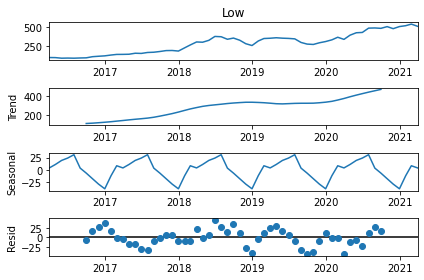

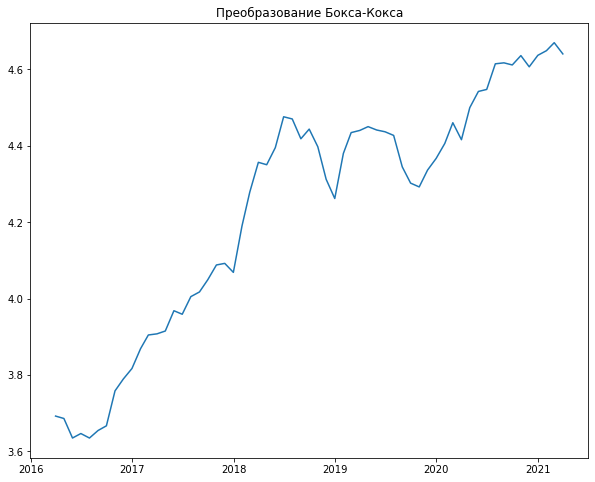

In [3]:
#TASK2.2 Поиск и удаление тренда
#Рассмотрим декомпозицию чтобы найти тренд и его удалить

from scipy.special import boxcox, inv_boxcox
import matplotlib.pyplot as plt

result = seasonal_decompose(df['Low'], model='additive')
result.plot()
#Есть тренд - увеличение во времени
#Есть сезоность и шумы
#Матожидание растет, дисперсия непостоянна 

#Делаем ряд стационарным 

#Удаляем сезонность
#Если просто продифферинцировать останутся проблемы с дисперсией, поэтому сначала стабилизируем ее
#Добавим преобразование Бокса-Кокса для стабилизации дисперсии
#Это обобщенное логарифмирование, с подобранной константой
#Отрицательных значений нет, делаем это смело
df.insert(1, 'LowBox',  boxcox(df["Low"], -0.1))
plt.figure(figsize=(10, 8))
plt.title('Преобразование Бокса-Кокса')
plt.plot(df.LowBox)
#Развернуть назад Бокса-Кокса можно inv_boxcox-ом 




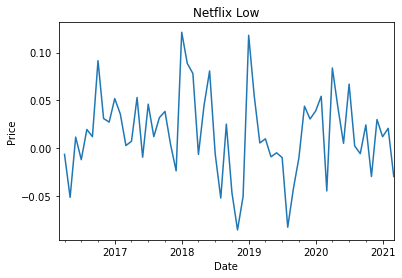

In [4]:

#Удаляем тренд - сделаем это дифференцированием
#Дифференцирование стабилизирует матожидание
from sympy import *
df.insert(2, 'LowDif', diff(df['LowBox']))
df.LowDif.plot(figsize=(6, 4), xlabel='Date', ylabel='Price', title='Netflix Low')
df.head()

#Бокс-кокс сам умеет откатываться а раздифферинцировать ряд мы так легко не можем
#Напишем кастомный интегратор который пригодистся в будущем для обратного преобразования

def cust_integrate(start, dif):
    to_integr = dif.copy()
    to_integr[0] = start[0]
    # возвращаем сумму с накоплением и возвращаем назад свои значения
    return to_integr.cumsum()


adf:  -6.238947264215871
p-value:  4.7491235438612186e-08
Critical values:  {'1%': -3.548493559596539, '5%': -2.912836594776334, '10%': -2.594129155766944}
единичных корней нет, ряд стационарен


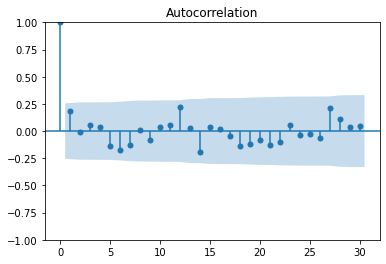

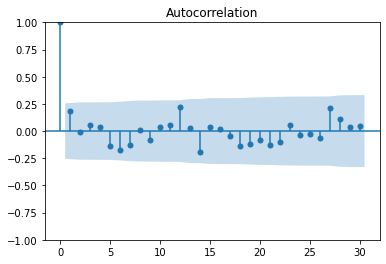

In [5]:
#Из нестационарного ряда предсказание не выйдет. Исходные ВР не стационарен по тесту Дикки-Фуллера
#ну и из всего вышесказанного
#Теперь проверим на стационарность полученный дифференированный ряд
#Тест на стационарность Дикки-Фуллера
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

test = adfuller(df.LowDif[2:])
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0] > test[4]['5%']:
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')
# Новый ряд стационарен, тренд удален
#result = seasonal_decompose(df['LowDif'][1:], model='additive')
#result.plot()
#plt.hist(df['LowDif'], density=True) визульная проверка на нормальность распределения
#plot_acf(df.Low[1:], lags=50) #изначальная
plot_acf(df.LowDif[2:], lags=30)  # строим корелограмму
#из графика видно что значимых корреляций нет
#По графику можно заметить что сезонность нужно будет далее поставить примерно 14


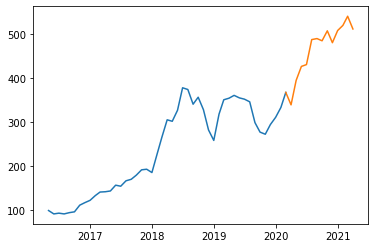

In [6]:
#TASK3. Обучите модель 
#Разбиваем данные на тренировочные и тестовые
train_df = df.LowDif[1:int(len(df)*0.80)]
test_df = df.LowDif[int(len(df)*0.78):]
plt.plot(df.Low[1:int(len(df)*0.80)])
plt.plot(df.Low[int(len(df)*0.78):])
plt.show()


In [7]:
#TASK3.1 Алгоритм 1
#ARIMA
#AR(p) - авторегрессия - регрессия значений ряда в прошлом
#MA(q) - скользящее среднее - линейн. комб. значений шума в пред q значений времени
#ARIMA(p,q,d) p - авторегрессионная компонента порядка p
#             q - компонента скользящего среднего порядка q
#             d - ряд продиффериенцирован d раз
#SARIMA - тоже самое но с сезонностью
!pip install pmdarima
#Строим несколько моделей и идет автовыбор лучшей
#Параметры крутились, но вышло так, что лучшая модель всегда была в диапазоне значений всех параметров [0;1]
from pmdarima.arima import auto_arima
from scipy.special import inv_boxcox, boxcox
model = auto_arima(
    train_df,
    start_p=0,
    start_q=0, 
    start_d=0,
    test='adf',
    max_p=2,
    max_q=2,
    max_d=2,
    m=12, #месяцев в году
    start_P=0, 
    max_P=1, 
    start_Q=0,
    max_Q=1,
    start_D=0,
    max_D=1,
    seasonal=True, 
    error_action ='ignore', 
    supress_warnings=True, 
    trace=True)

model.summary()
#Best model:  ARIMA(0,1,1)(0,0,1)[12]


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-133.658, Time=1.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-135.707, Time=0.38 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-144.018, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-135.631, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-143.431, Time=0.22 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-133.197, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-135.799, Time=0.10 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=-143.504, Time=0.32 sec
 ARIMA(0,1,1)(0,0,1)[12]             : AIC=-145.955, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=-144.115, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[12]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   47
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 12)   Log Likelihood                  75.977
Date:                            Tue, 27 Dec 2022   AIC                           -145.955
Time:                                    15:38:40   BIC                           -140.469
Sample:                                04-30-2016   HQIC                          -143.900
                                     - 02-29-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8626      0.073    -11.786      0.000      -1.006      -0.719
ma.S.L12       0.3444      0.162      2.130      0.033       0.028       0.661
sigma2         0.0020      0.001      3.818      0.000       0.001       0.003
===================================================================================
Ljung-Box (L1) (Q):                   1.94   Jarque-Bera (JB):                 0.50
Prob(Q):                              0.16   Prob(JB):                         0.78
Heteroskedasticity (H):               1.65   Skew:                             0.11
Prob(H) (two-sided):                  0.34   Kurtosis:                         2.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

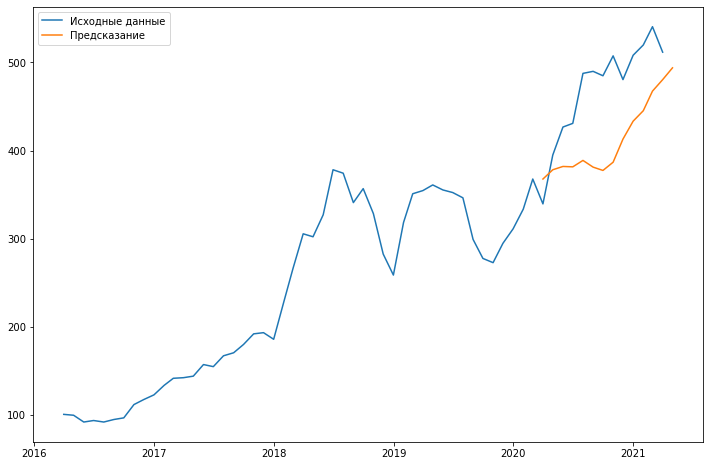

In [8]:
import matplotlib.pyplot as plt

fitted, confint = model.predict(n_periods=len(test_df), return_conf_int=True)
fitted = pd.Series(fitted)
#plt.plot(inv_boxcox(cust_integrate(df.LowBox, df.LowDif), -0.1)) - проверка что с обратнымми преобразованиями все ок

#Разворачиваем предсказание в вид бокса кокса и потом делаем по нему антилогарифмирование
arima_predicted = inv_boxcox(cust_integrate(df.LowBox[int(len(df)*0.78):], fitted), -0.1)
#Строим график чтобы сравнить предстказание с реальностью
plt.figure(figsize=(12, 8))
plt.plot(df.Low, label="Исходные данные")
plt.plot(arima_predicted, label="Предсказание")
plt.legend()
plt.show()

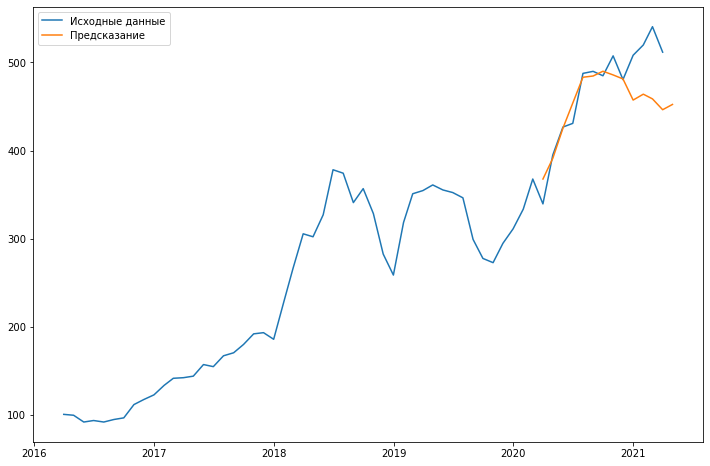

In [9]:
#TASK3.2 Алгоритм 2
#Модель Хольта-Уинтерса(тройное экспоненциальное сглаживание)
from statsmodels.tsa.holtwinters import ExponentialSmoothing
#Тренд, уровень и сезонность
model = ExponentialSmoothing(
    df.LowDif[1:int(len(df)*0.80)],
    trend="add",
    seasonal="add",
    seasonal_periods=14)
fit = model.fit()
fitted = fit.forecast(len(test_df))
fitted1 = pd.Series(fitted)
holt_predicted = inv_boxcox(cust_integrate(
    df.LowBox[int(len(df)*0.78):], fitted1), -0.1)
#holt_predicted = pd.Series(fitted)
plt.figure(figsize=(12, 8))
plt.plot(df.Low, label="Исходные данные")
plt.plot(holt_predicted, label="Предсказание")
plt.legend()
plt.show()

In [10]:
#TASK4. Метрика
#Для оценки разности истинного и предсказанного воспользуемся метрикой MAPE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import statsmodels.tsa.api as smt

arima_error = mean_absolute_percentage_error(
    df.Low[int(len(df)*0.78):], arima_predicted)
print("ARIMA mape is ", arima_error)
holt_error = mean_absolute_percentage_error(
    df.Low[int(len(df)*0.78):], holt_predicted)
print("Holt-Winters mape is ", holt_error)


ARIMA mape is  0.11832111279598771
Holt-Winters mape is  0.07275804445289343
